In [1]:
# Qiskit imports
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import sys
module_path = os.path.abspath(os.path.join('/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Qiskit imports
from qiskit import pulse, transpile
from qiskit.transpiler import InstructionDurations
from qiskit.circuit import ParameterVector, QuantumCircuit, QuantumRegister, Gate, \
    ParameterExpression, CircuitInstruction
# from qiskit.circuit.random import random_circuit
# from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_ibm_runtime.options import SimulatorOptions, TranspilationOptions
from qiskit.providers import Backend
from qiskit.providers.fake_provider import FakeJakartaV2, FakeJakarta, FakeHanoi, FakePerth
from qiskit_aer import AerSimulator
from qiskit.circuit.library import XGate, CXGate

from qconfig import QiskitConfig
from quantumenvironment import QuantumEnvironment
from torch_quantum_environment import TorchQuantumEnvironment
from gymnasium.spaces import Box, Space
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.distributions import Normal

import numpy as np
import tqdm
import time
from typing import Union, Optional, List, Sequence
from IPython.display import clear_output

# Circuit macros for environment

In [2]:
def custom_pulse_schedule(backend: Backend, qubit_tgt_register: Union[List[int], QuantumRegister],
                          params: Union[Sequence[ParameterExpression], ParameterVector],
                          default_schedule: Optional[Union[pulse.ScheduleBlock, pulse.Schedule]] = None):
    """
    Define parametrization of the pulse schedule characterizing the target gate
        :param backend: IBM Backend on which schedule shall be added
        :param qubit_tgt_register: Qubit register on which
        :param params: Parameters of the Schedule
        :param default_schedule:  baseline from which one can customize the pulse parameters

        :return: Parametrized Schedule
    """

    if default_schedule is None:  # No baseline pulse, full waveform builder
        pass
    else:

        # Look here for the pulse features to specifically optimize upon, for the x gate here, simply retrieve relevant
        # parameters for the Drag pulse
        pulse_ref = default_schedule.instructions[0][1].pulse

        with pulse.build(backend=backend, name='param_schedule') as parametrized_schedule:

            pulse.play(pulse.Drag(duration=pulse_ref.duration, amp=params[0], sigma=pulse_ref.sigma,
                                  beta=pulse_ref.beta, angle=pulse_ref.angle),
                       channel=pulse.DriveChannel(qubit_tgt_register[0]))

        return parametrized_schedule

In [3]:
def param_circuit(qc: QuantumCircuit,
              params: Optional[ParameterVector]=None, q_reg: Optional[QuantumRegister] = None):
# To build a unique gate identifier, choose the name based on the input circuit name (by default and if used
# with TFQuantumEnvironment class, this circuit name is of the form c_circ_trunc_{i})
# custom_gate_name = f"{target['gate'].name}_{qc.name[-1]}"
# custom_gate = Gate(custom_gate_name, len(target["register"]), params=params.params)
# custom_sched = custom_pulse_schedule(backend=backend, qubit_tgt_register=physical_qubits, params=params,
#                                      default_schedule=backend.target.get_calibration(target["gate"].name,
#                                                                                      tuple(physical_qubits)))
# qc.add_calibration(custom_gate, physical_qubits, custom_sched)
# qc.append(custom_gate, physical_qubits)
    if params is None:
        params = ParameterVector("a", n_actions)
    my_qc = QuantumCircuit(2, name="custom_cx")
    optimal_params = np.pi * np.array([0., 0., 0.5, 0.5, -0.5, 0.5, -0.5])
    
    my_qc.u(optimal_params[0]+params[0], optimal_params[1]+params[1], optimal_params[2]+params[2], 0)
    my_qc.u(optimal_params[3]+params[3], optimal_params[4]+params[4], optimal_params[5]+params[5], 1)
    my_qc.rzx(optimal_params[6]+params[6], 0, 1)
    #my_qc.u(np.pi *params[0], np.pi *params[1], np.pi *params[2], 0)
    #my_qc.u(np.pi *params[3], np.pi *params[4], np.pi *params[5], 1)
    #my_qc.rzx(np.pi * params[6], 0, 1)
    qc.append(my_qc.to_instruction(label="custom_cx"), physical_qubits)
    # qc.rx(2 * np.pi * params[0], physical_qubits)

# Definition of QuantumEnvironment

In [4]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
sampling_Paulis = 100
N_shots = 20 # Number of shots for sampling the quantum computer for each action vector
fake_backend = FakeJakartaV2()
service = QiskitRuntimeService(channel='ibm_quantum', instance='ibm-q-nus/default/default')
runtime_backend = service.backend("ibmq_qasm_simulator")
runtime_backend.instruction_durations.update(fake_backend.instruction_durations)
estimator_options = Options(simulator= SimulatorOptions().set_backend(fake_backend))
backend = runtime_backend
target_gate = CXGate()
physical_qubits = [0, 1]
n_qubits = len(physical_qubits)
target = {"gate": target_gate, 'register': physical_qubits}
config = QiskitConfig(parametrized_circuit=param_circuit, backend=backend, estimator_options=estimator_options)

q_env = QuantumEnvironment(target, "circuit", config)
q_env

QuantumEnvironment composed of 2, 
Defined target: gate (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]))
Defined backend: <IBMBackend('ibmq_qasm_simulator')>,
Abstraction level: circuit,

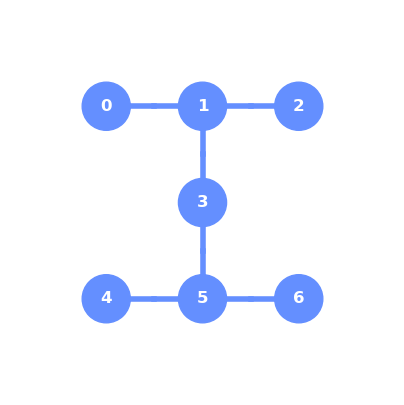

In [5]:
from qiskit.visualization import plot_coupling_map, plot_circuit_layout, gate_map, plot_gate_map
from qiskit.visualization.pulse_v2 import IQXDebugging
plot_gate_map(fake_backend)

# Definition of TorchQuantumEnvironment

In [6]:
# Circuit context
seed = 10
training_steps_per_gate = 3
# target_circuit = transpile(random_circuit(4, depth=2, max_operands=2, seed=seed), backend)
target_circuit = QuantumCircuit(2)
target_circuit.cx(0,1)

# target_circuit = transpile(target_circuit, backend, optimization_level=0)
# tgt_qubits = [target_circuit.qubits[i] for i in physical_qubits]

# tgt_instruction_counts = target_circuit.data.count(CircuitInstruction(target_gate, tgt_qubits))
tgt_instruction_counts = 1
batchsize = 500  # Batch size (iterate over a bunch of actions per policy to estimate expected return) default 100
n_actions = 7  # Choose how many control parameters in pulse/circuit parametrization
optimal_params = np.pi * np.array([0., 0., 0.5, 0.5, -0.5, 0.5, -0.5])
min_bound_actions =  - 0.05
max_bound_actions =  0.05
scale_factor = 0.05
observation_space = Box(low=np.array([0, 0]), high=np.array([1, tgt_instruction_counts]), shape=(2,),
                        seed=seed)
action_space = Box(low=min_bound_actions, high=max_bound_actions, shape=(n_actions,), seed=seed)

torch_env = TorchQuantumEnvironment(q_env, target_circuit, action_space, observation_space, batch_size=batchsize,
                                    training_steps_per_gate=training_steps_per_gate, intermediate_rewards=False,
                                    seed=None)


/Users/arthurstrauss/opt/anaconda3/envs/rl_qoc/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


# Definition of the Agent

In [7]:
class ActorNetwork(nn.Module):
    def __init__(self, observation_space: Space, hidden_layers: Sequence[int],
                 n_actions: int,
                 hidden_activation_functions: Optional[Sequence[nn.Module]] = None,
                 include_critic=True,
                 chkpt_dir: str = 'tmp/ppo'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_dir = chkpt_dir
        # Define a list to hold the layer sizes including input and output sizes
        layer_sizes = [observation_space.shape[0]] + list(hidden_layers)
        if hidden_activation_functions is None:
            hidden_activation_functions = [nn.ReLU() for _ in range(len(layer_sizes))]

        assert len(hidden_activation_functions) == len(layer_sizes)
        # Define a list to hold the layers of the network
        layers = []

        # Iterate over the layer sizes to create the network layers
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer with the current and next layer sizes
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

            layers.append(hidden_activation_functions[i])

        # Create the actor network using Sequential container
        self.layers = layers
        self.mean_action = nn.Linear(hidden_layers[-1], n_actions)
        self.mean_activation = nn.Tanh()
        self.std_action = nn.Linear(hidden_layers[-1], n_actions)
        self.std_activation = nn.Sigmoid()

        self.include_critic = include_critic
        self.critic_output = nn.Linear(hidden_layers[-1], 1)

        self.base_network = nn.Sequential(*layers)

        # Initialize the weights of the network
        for layer in self.base_network.modules():
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight)
                nn.init.constant_(layer.bias, 0.)

    def forward(self, x):
        x = self.base_network(x)
        mean_action = self.mean_action(x)
        mean_action = self.mean_activation(mean_action)
        std_action = self.std_action(x)
        std_action = self.std_activation(std_action)
        critic_output = self.critic_output(x)

        if self.critic_output:
            return mean_action, std_action, critic_output
        else:
            return mean_action, std_action

    def get_value(self, x):
        x = self.base_network(x)
        x = self.critic_output(x)
        return x

    def save_checkpoint(self):
        torch.save(self, self.checkpoint_dir)

    def load_checkpoint(self):
        torch.load(self.checkpoint_dir)


class CriticNetwork(nn.Module):
    def __init__(self, observation_space: Space, hidden_layers: Sequence[int],
                 hidden_activation_functions: Optional[Sequence[nn.Module]] = None,
                 chkpt_dir: str = 'tmp/critic_ppo'):
        super(CriticNetwork, self).__init__()
        self.checkpoint_dir = chkpt_dir
        # Define a list to hold the layer sizes including input and output sizes
        layer_sizes = [observation_space.shape[0]] + list(hidden_layers)
        if hidden_activation_functions is None:
            hidden_activation_functions = [nn.ReLU() for _ in range(len(layer_sizes))]

        assert len(hidden_activation_functions) == len(layer_sizes)
        # Define a list to hold the layers of the network
        layers = []

        # Iterate over the layer sizes to create the network layers
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer with the current and next layer sizes
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

            # Add a ReLU activation function for all layers except the output layer

            layers.append(hidden_activation_functions[i])

        # Create the actor network using Sequential container
        self.layers = layers
        self.critic_output = nn.Linear(hidden_layers[-1], 1)
        self.layers.append(self.critic_output)
        self.critic_network = nn.Sequential(*self.layers)

        # Initialize the weights of the network
        for layer in self.critic_network.modules():
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight)
                nn.init.constant_(layer.bias, 0.)

    def forward(self, x):
        return self.critic_network(x)

    def save_checkpoint(self):
        torch.save(self, self.checkpoint_dir)

    def load_checkpoint(self):
        torch.load(self.checkpoint_dir)


class Agent(nn.Module):
    def __init__(self, actor_net: ActorNetwork, critic_net: Optional[CriticNetwork]=None):
        super().__init__()

        self.actor_net = actor_net
        self.critic_net = critic_net

        if self.critic_net is not None:
            assert not self.actor_net.include_critic, "Critic already included in Actor Network"

    def forward(self, x):
        if self.actor_net.include_critic:
            return self.actor_net(x)
        else:
            assert self.critic_net is not None, 'Critic Network not provided and not included in ActorNetwork'
            mean_action, std_action = self.actor_net(x)
            value = self.critic_net(x)
            return mean_action, std_action, value

    def get_value(self, x):
        if self.actor_net.include_critic:
            return self.actor_net.get_value(x)
        else:
            assert self.critic_net is not None, 'Critic Network not provided and not included in ActorNetwork'
            return self.critic_net(x)

    def save_checkpoint(self):
        self.actor_net.save_checkpoint()
        if self.critic_net is not None:
            self.critic_net.save_checkpoint()


In [8]:
activation_functions = [nn.Tanh(), nn.Tanh(), nn.Tanh()]
actor_net = ActorNetwork(observation_space, [64, 64], n_actions, activation_functions).to(device)
#actor_net = ActorNetwork(observation_space, [128, 128], n_actions).to(device)
critic_net = CriticNetwork(observation_space, [128, 128], [nn.ELU(), nn.ELU(), nn.ELU()]).to(device)
agent = Agent(actor_net, critic_net=None).to(device)

## Hyperparameters for training

In [9]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""
run_name = "test"
writer = SummaryWriter(f"runs/{run_name}")
# writer.add_text(
#     "hyperparameters",
#     "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
# )
# Hyperparameters for the agent
n_epochs = 10  # Number of epochs : default 1500
num_updates = 3000
opti = "Adam"
lr_actor = 0.0001  # Learning rate for policy update step
lr_critic = 0.0018  # Learning rate for critic (value function) update step

epsilon = 0.2  # Parameter for clipping value (PPO)
critic_loss_coeff = 0.5
optimizer = optim.Adam(agent.parameters(), lr=lr_actor, eps=1e-5)
actor_optimizer = optim.Adam(actor_net.parameters(), lr=lr_actor, eps=1e-5)
critic_optimizer = optim.Adam(critic_net.parameters(), lr=lr_critic, eps=1e-5)
minibatch_size = 40
gamma = 1.
gae_lambda = 0.95

# Clipping
clip_vloss = True
grad_clip = 0.5
clip_coef = 0.5
normalize_advantage = False

# other coefficients
ent_coef = 0.

# Training
## Storage setup

In [10]:
global_step = 0
torch_env.clear_history()
obs = torch.zeros((tgt_instruction_counts, batchsize) + torch_env.observation_space.shape).to(device)
actions = torch.zeros((tgt_instruction_counts, batchsize) + torch_env.action_space.shape).to(device)
logprobs = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
rewards = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
dones = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
values = torch.zeros((tgt_instruction_counts, batchsize)).to(device)

train_obs = torch.zeros((batchsize,) + torch_env.observation_space.shape, requires_grad=True).to(device)
visualization_steps = 10

## Main loop

In [11]:
for update in tqdm.tqdm(range(1, num_updates + 1)):
    next_obs, _ = torch_env.reset(seed=seed)
    num_steps = torch_env.episode_length(global_step)
    next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
    next_done = torch.zeros(batchsize).to(device)

    # print("episode length:", num_steps)

    for step in range(num_steps):
        global_step += 1
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            mean_action, std_action, critic_value = agent(next_obs)
            mean_action*=scale_factor
            std_action*=scale_factor
            probs = Normal(mean_action, std_action)
            action = torch.clip(probs.sample(), torch.Tensor(np.array(min_bound_actions)), torch.Tensor(np.array(max_bound_actions)))
            logprob = probs.log_prob(action).sum(1)
            values[step] = critic_value.flatten()

        actions[step] = action
        logprobs[step] = logprob
        # next_obs, reward, terminated, truncated, infos = torch_env.step(action.cpu().numpy())
        next_obs, reward, terminated, truncated, infos = torch_env.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device)
        next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
        next_done = torch.Tensor(np.array([int(done)] * batchsize)).to(device)
        # Only print when at least 1 env is done

        # print(f"global_step={global_step}, episodic_return={np.mean(reward)}")
        writer.add_scalar("charts/episodic_return", np.mean(reward), global_step)
        writer.add_scalar("charts/episodic_length", num_steps, global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + torch_env.observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + torch_env.action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batchsize)
    clipfracs = []
    for epoch in range(n_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batchsize, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]
            new_mean, new_sigma, new_value = agent(b_obs[mb_inds])
            new_dist = Normal(new_mean, new_sigma)
            new_logprob, entropy = new_dist.log_prob(b_actions[mb_inds]).sum(1), new_dist.entropy().sum(1)
            logratio = new_logprob - b_logprobs[mb_inds] + torch.log(torch.Tensor([1e-6]))
            ratio = logratio.exp()
            #print('new_logprob', new_logprob)
            #print('b_logprobs[mb_inds]', b_logprobs[mb_inds])
            #print("logratio", logratio)
            #print('ratio', ratio)
            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > epsilon).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if normalize_advantage:  # Normalize advantage
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = new_value.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * critic_loss_coeff

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), grad_clip)
            optimizer.step()

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y
    print("mean", mean_action[0])
    print("sigma", std_action[0])
    print("Average return:", np.mean(torch_env.reward_history, axis=1)[-1])
    # print(np.mean(torch_env.reward_history, axis =1)[-1])
    print("Circuit fidelity:", torch_env.circuit_fidelity_history[-1])
    print("Avg gate fidelity:", torch_env.avg_fidelity_history[-1])   
    print(torch_env._get_info())
    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/avg_return", np.mean(torch_env.reward_history, axis=1)[-1], global_step)
    for i in range(num_steps):
        writer.add_scalar(f"losses/avg_gate_{i}_fidelity", torch_env.avg_fidelity_history[-1][i], global_step)
    writer.add_scalar("losses/circuit_fidelity", torch_env.circuit_fidelity_history[-1], global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    if global_step%visualization_steps == 0:
        clear_output(wait=True) # for animation

torch_env.close()
writer.close()


  1%|▍                                     | 30/3000 [12:51<24:53:42, 30.18s/it]

Sending job...
Job done


  1%|▍                                     | 31/3000 [13:20<24:28:27, 29.68s/it]

mean tensor([ 0.0087, -0.0053, -0.0210,  0.0143,  0.0217,  0.0001, -0.0218])
sigma tensor([0.0282, 0.0239, 0.0276, 0.0240, 0.0246, 0.0254, 0.0337])
Average return: 4.000000000000001
Circuit fidelity: 0.9992310216458781
Avg gate fidelity: [0.99885253]
{'reset_stage': False, 'step': 31, 'average gate fidelity': array([0.99885253]), 'average return': 4.000000000000001, 'circuit fidelity': 0.9992310216458781, 'max return': 5.333333333333335, 'max circuit fidelity': 0.9994018111685592, 'max avg gate fidelity': [0.9992006505769201], 'arg max avg gate fidelity': [1], 'arg max return': 15, 'arg max circuit fidelity': 1, 'best action': array([ 0.00715834, -0.00630317, -0.01835124,  0.0133325 ,  0.01729651,
        0.00021029, -0.01743464]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[3, 3]', 'observable': SparsePauliOp(['II', 'XY', 'YZ', 'ZX'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])}
Sending job...
Job done


  1%|▍                                     | 32/3000 [13:43<22:44:36, 27.59s/it]

mean tensor([ 0.0050, -0.0060, -0.0154,  0.0117,  0.0198, -0.0018, -0.0173])
sigma tensor([0.0278, 0.0242, 0.0268, 0.0237, 0.0250, 0.0251, 0.0319])
Average return: 3.999999999999999
Circuit fidelity: 0.9992719218386465
Avg gate fidelity: [0.99893534]
{'reset_stage': False, 'step': 32, 'average gate fidelity': array([0.99893534]), 'average return': 3.999999999999999, 'circuit fidelity': 0.9992719218386465, 'max return': 5.333333333333335, 'max circuit fidelity': 0.9994018111685592, 'max avg gate fidelity': [0.9992006505769201], 'arg max avg gate fidelity': [1], 'arg max return': 15, 'arg max circuit fidelity': 1, 'best action': array([ 0.00715834, -0.00630317, -0.01835124,  0.0133325 ,  0.01729651,
        0.00021029, -0.01743464]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[1, 3]', 'observable': SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j])}
Sending job...
Job done


  1%|▍                                     | 33/3000 [14:05<21:21:32, 25.92s/it]

mean tensor([ 0.0060, -0.0058, -0.0173,  0.0125,  0.0209, -0.0015, -0.0188])
sigma tensor([0.0280, 0.0240, 0.0270, 0.0236, 0.0250, 0.0250, 0.0325])
Average return: 3.999999999999999
Circuit fidelity: 0.9992780543635283
Avg gate fidelity: [0.99893377]
{'reset_stage': False, 'step': 33, 'average gate fidelity': array([0.99893377]), 'average return': 3.999999999999999, 'circuit fidelity': 0.9992780543635283, 'max return': 5.333333333333335, 'max circuit fidelity': 0.9994018111685592, 'max avg gate fidelity': [0.9992006505769201], 'arg max avg gate fidelity': [1], 'arg max return': 15, 'arg max circuit fidelity': 1, 'best action': array([ 0.00715834, -0.00630317, -0.01835124,  0.0133325 ,  0.01729651,
        0.00021029, -0.01743464]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[2, 2]', 'observable': SparsePauliOp(['II', 'IX', 'XI', 'XX'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])}
Sending job...
Job done


  1%|▍                                     | 34/3000 [14:28<20:48:38, 25.26s/it]

mean tensor([ 0.0055, -0.0059, -0.0168,  0.0122,  0.0211, -0.0020, -0.0183])
sigma tensor([0.0281, 0.0240, 0.0268, 0.0234, 0.0252, 0.0248, 0.0323])
Average return: 4.000000000000001
Circuit fidelity: 0.9993014434351782
Avg gate fidelity: [0.9989187]
{'reset_stage': False, 'step': 34, 'average gate fidelity': array([0.9989187]), 'average return': 4.000000000000001, 'circuit fidelity': 0.9993014434351782, 'max return': 5.333333333333335, 'max circuit fidelity': 0.9994018111685592, 'max avg gate fidelity': [0.9992006505769201], 'arg max avg gate fidelity': [1], 'arg max return': 15, 'arg max circuit fidelity': 1, 'best action': array([ 0.00715834, -0.00630317, -0.01835124,  0.0133325 ,  0.01729651,
        0.00021029, -0.01743464]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[2, 3]', 'observable': SparsePauliOp(['II', 'XX', 'YZ', 'ZY'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])}
Sending job...
Job done


  1%|▍                                     | 35/3000 [15:04<23:17:31, 28.28s/it]

mean tensor([ 0.0051, -0.0060, -0.0161,  0.0119,  0.0207, -0.0022, -0.0177])
sigma tensor([0.0280, 0.0241, 0.0267, 0.0234, 0.0252, 0.0248, 0.0320])
Average return: 3.999999999999999
Circuit fidelity: 0.9992918432339475
Avg gate fidelity: [0.99896989]
{'reset_stage': False, 'step': 35, 'average gate fidelity': array([0.99896989]), 'average return': 3.999999999999999, 'circuit fidelity': 0.9992918432339475, 'max return': 5.333333333333335, 'max circuit fidelity': 0.9994018111685592, 'max avg gate fidelity': [0.9992006505769201], 'arg max avg gate fidelity': [1], 'arg max return': 15, 'arg max circuit fidelity': 1, 'best action': array([ 0.00715834, -0.00630317, -0.01835124,  0.0133325 ,  0.01729651,
        0.00021029, -0.01743464]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[2, 2]', 'observable': SparsePauliOp(['II', 'IX', 'XI', 'XX'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])}
Sending job...
Job done


  1%|▍                                     | 36/3000 [15:40<25:13:51, 30.64s/it]

mean tensor([ 0.0038, -0.0062, -0.0132,  0.0109,  0.0184, -0.0021, -0.0154])
sigma tensor([0.0276, 0.0244, 0.0266, 0.0238, 0.0250, 0.0251, 0.0312])
Average return: 3.999999999999999
Circuit fidelity: 0.9993160790104669
Avg gate fidelity: [0.99898544]
{'reset_stage': False, 'step': 36, 'average gate fidelity': array([0.99898544]), 'average return': 3.999999999999999, 'circuit fidelity': 0.9993160790104669, 'max return': 5.333333333333335, 'max circuit fidelity': 0.9994018111685592, 'max avg gate fidelity': [0.9992006505769201], 'arg max avg gate fidelity': [1], 'arg max return': 15, 'arg max circuit fidelity': 1, 'best action': array([ 0.00715834, -0.00630317, -0.01835124,  0.0133325 ,  0.01729651,
        0.00021029, -0.01743464]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[1, 0]', 'observable': SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j])}
Sending job...
Job done


  1%|▍                                     | 37/3000 [16:03<23:18:35, 28.32s/it]

mean tensor([ 0.0067, -0.0058, -0.0180,  0.0128,  0.0209, -0.0009, -0.0195])
sigma tensor([0.0280, 0.0240, 0.0271, 0.0238, 0.0249, 0.0253, 0.0327])
Average return: 5.333333333333332
Circuit fidelity: 0.9992694010102249
Avg gate fidelity: [0.99892084]
{'reset_stage': False, 'step': 37, 'average gate fidelity': array([0.99892084]), 'average return': 5.333333333333332, 'circuit fidelity': 0.9992694010102249, 'max return': 5.333333333333335, 'max circuit fidelity': 0.9994018111685592, 'max avg gate fidelity': [0.9992006505769201], 'arg max avg gate fidelity': [1], 'arg max return': 15, 'arg max circuit fidelity': 1, 'best action': array([ 0.00715834, -0.00630317, -0.01835124,  0.0133325 ,  0.01729651,
        0.00021029, -0.01743464]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[2, 1]', 'observable': SparsePauliOp(['II', 'XX', 'YY'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j])}
Sending job...
Job done


  1%|▍                                     | 38/3000 [16:24<21:34:45, 26.23s/it]

mean tensor([ 0.0051, -0.0061, -0.0143,  0.0115,  0.0174, -0.0007, -0.0166])
sigma tensor([0.0274, 0.0245, 0.0271, 0.0245, 0.0245, 0.0258, 0.0317])
Average return: 3.999999999999999
Circuit fidelity: 0.9992650351367836
Avg gate fidelity: [0.99895881]
{'reset_stage': False, 'step': 38, 'average gate fidelity': array([0.99895881]), 'average return': 3.999999999999999, 'circuit fidelity': 0.9992650351367836, 'max return': 5.333333333333335, 'max circuit fidelity': 0.9994018111685592, 'max avg gate fidelity': [0.9992006505769201], 'arg max avg gate fidelity': [1], 'arg max return': 15, 'arg max circuit fidelity': 1, 'best action': array([ 0.00715834, -0.00630317, -0.01835124,  0.0133325 ,  0.01729651,
        0.00021029, -0.01743464]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[0, 0]', 'observable': SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])}
Sending job...
Job done


  1%|▍                                     | 39/3000 [16:46<20:29:26, 24.91s/it]

mean tensor([ 0.0054, -0.0061, -0.0149,  0.0117,  0.0179, -0.0007, -0.0171])
sigma tensor([0.0275, 0.0245, 0.0271, 0.0244, 0.0245, 0.0258, 0.0318])
Average return: 4.000000000000001
Circuit fidelity: 0.999281165725429
Avg gate fidelity: [0.99897957]
{'reset_stage': False, 'step': 39, 'average gate fidelity': array([0.99897957]), 'average return': 4.000000000000001, 'circuit fidelity': 0.999281165725429, 'max return': 5.333333333333335, 'max circuit fidelity': 0.9994018111685592, 'max avg gate fidelity': [0.9992006505769201], 'arg max avg gate fidelity': [1], 'arg max return': 15, 'arg max circuit fidelity': 1, 'best action': array([ 0.00715834, -0.00630317, -0.01835124,  0.0133325 ,  0.01729651,
        0.00021029, -0.01743464]), 'truncation_index': 0, 'input_state': 'PauliPreparationBasis[0, 1]', 'observable': SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j])}
Sending job...


  1%|▍                                     | 39/3000 [17:01<21:32:35, 26.19s/it]


KeyboardInterrupt: 

In [12]:
torch_env.close()
writer.close()

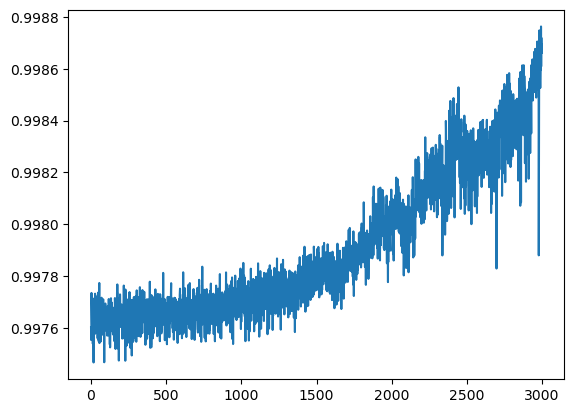

In [13]:
import matplotlib.pyplot as plt
plt.plot(torch_env.circuit_fidelity_history)

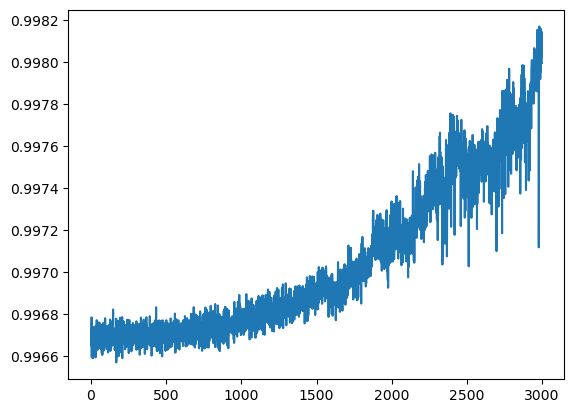

In [14]:
plt.plot(torch_env.avg_fidelity_history)

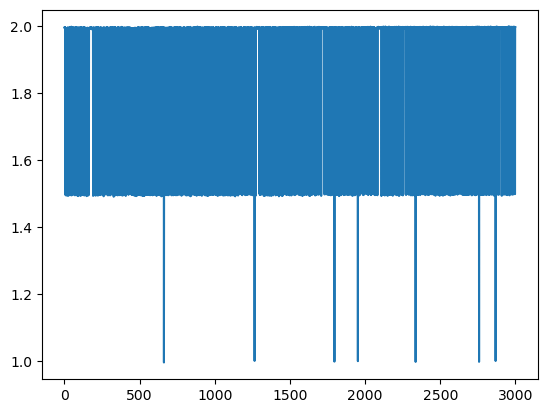

In [15]:
plt.plot(np.mean(torch_env.reward_history, axis=1))

In [16]:
from qiskit.quantum_info import Operator, average_gate_fidelity
from qiskit.circuit.library.standard_gates import CXGate
my_qc = QuantumCircuit(2, name="custom_cx")
optimal_params = [0., 0., 0.5, 0.5, -0.5, 0.5, -0.5]
params = [-0.0062,  0.2190,  0.9921,  0.9924, -0.9921,  0.9910, -0.9907]
my_qc.u(np.pi * params[0], np.pi * params[1], np.pi * params[2], 0)
my_qc.u(np.pi * params[3], np.pi * params[4], np.pi * params[5], 1)
my_qc.rzx(np.pi * params[6], 0, 1)
average_gate_fidelity(Operator(my_qc), Operator(CXGate()))

0.20009201464808402

In [17]:
mean tensor([ 0.0706, -0.0553,  0.0329,  0.0496, -0.1285,  0.1071,  0.1628])
sigma tensor([0.4565, 0.4977, 0.5308, 0.5297, 0.4840, 0.5090, 0.5176])

SyntaxError: invalid syntax (2427439725.py, line 1)